In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras import applications
import os
import csv
import sys
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import tensorflow.keras.backend as K

maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

csv.field_size_limit(maxInt)

922337203

In [2]:
os.chdir('D:/hubmap segmentation challenge/')

In [3]:
data = pd.read_csv('train.csv').values

In [4]:
train_data = data[:-int(len(data)/3)]
val_data = data[-int(len(data)/3):]

In [5]:
organs = np.unique(data[:,1])
sexes = np.unique(data[:,-1])

In [6]:
def rle_to_mask(rle_string, size):
    rle = np.array(list(map(int, rle_string.split())))
    label = np.zeros((size*size), dtype=np.uint8)
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1
    return label.reshape(size, size).T

In [7]:
def augment_data(image, mask, img_size):
    """augments the data by cropping and flipping randomly"""
    flip = np.random.choice([True, False])
    crop = np.random.choice([True, False])
    image_dim = len(image)
    
    if crop:
        x1, x2 = np.random.randint(0,image_dim),np.random.randint(0,image_dim)
        left = np.min([x1,x2])
        right = np.max([x1,x2])
        if right - left >= img_size[0]:
            image = image[left:right, left:right]
            mask = mask[left:right, left:right]
    
    if flip:
        axis_to_flip = random.choice([0,1])
        image = np.flip(image, axis_to_flip)
        mask = np.flip(mask, axis_to_flip)
    
    image = cv2.resize(image, img_size)
    mask = cv2.resize(mask, img_size)
    
    return image, mask

In [8]:
def return_batch(data, batch_size, img_size, augment = True):
    """format of the data in the csv is id, organ, data_source, img_height, img_width, pixel_size, tissue_thickness, rle, age, sex"""
    
    images = []
    masks = []
    
    indices = np.random.choice(range(len(data)), (batch_size))
    
    for i in range(0,len(indices)):
        
        image = (cv2.imread(('train_images/'+str(data[indices[i]][0])+'.tiff')))
        image = image/255
        
        rle_string = data[indices[i]][-3]
        img_height = data[indices[i]][3]
        
        mask = rle_to_mask(rle_string, img_height)
        
        if augment:
            image, mask = augment_data(image, mask, img_size)
        else:
            image = cv2.resize(image, (img_size))
            mask = cv2.resize(mask, (img_size))
        
        
        masks.append(mask)
        images.append(image)
    
    return images, masks
    
    
        
    

In [9]:
class KSAC_layer(tf.keras.layers.Layer):
    def __init__(self, input_shape, filters, dilation_rates=[6, 12, 18], batchnorm=True):
        super().__init__()
        self.dilation_rates = dilation_rates
        self.batchnorms = []
        self.filters = filters
        if batchnorm:
            self.batchnorms = [tf.keras.layers.BatchNormalization() for _ in dilation_rates]
        self.kernel_initializer = tf.keras.initializers.GlorotUniform()
        self.kernel_shape = (3, 3, input_shape[-1], filters)
        self.kernel = tf.Variable(self.kernel_initializer(self.kernel_shape), trainable=True)

    def call(self, x, training=False):
        feature_maps = [tf.nn.conv2d(x, self.kernel, (1, 1), 'SAME', dilations=d) for d in self.dilation_rates]
        if len(self.batchnorms) > 0:
            for i in range(len(feature_maps)):
                feature_maps[i] = self.batchnorms[i](feature_maps[i], training=training)
        return sum(feature_maps)

In [10]:
class KSAC_pooling(tf.keras.layers.Layer):
    def __init__(self, filters, batchnorm = False):
        super().__init__()
        self.filters = filters
        self.batchnorm = []
        if batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()
        self.conv_layer = tf.keras.layers.Conv2D(filters, 1, (1,1))

    def call(self, x):
        x = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(x)
        x = self.conv_layer(x)
        if self.batchnorm != []:
            x = self.batchnorm(x)
        return tf.image.resize(images=x, size=x.shape[1:-1])

In [11]:
class KSAC_block(tf.keras.layers.Layer):
    def __init__(self, filters, input_shape, dilation_rate=[6, 12, 18], batchnorm=True):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, 1, (1, 1))
        self.batchnorm = []
        if batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()


        self.ksac_layer = KSAC_layer(input_shape, filters, dilation_rate, batchnorm)
        self.ksac_pooling = KSAC_pooling(filters, batchnorm)
        self.bias = tf.Variable(tf.zeros_initializer()((filters,)), trainable=True, name='bias')

    def call(self, x):
        y = self.conv1(x)
        if self.batchnorm != []:
            y = self.batchnorm(y)
        return tf.nn.relu(y + self.ksac_layer(x) + self.ksac_pooling(x) + self.bias)

In [12]:
class DeepLabV3_Decoder(tf.keras.layers.Layer):
    def __init__(self, filters, out_size, batchnorm=True):
        super().__init__()
        self.batchnorm = []
        if batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters, 1, (1, 1))
        self.conv2 = tf.keras.layers.Conv2D(1, 3, (1, 1), "SAME", activation='sigmoid')
        self.out_size = out_size

    def call(self, x1, x2):
        x2 = self.conv1(x2)
        x2 = self.batchnorm(x2)
        x2 = tf.nn.relu(x2)
        x2 = tf.image.resize(images=x2, size=x1.shape[1:-1])
        x = tf.concat([x1, x2], axis=-1)
        x = self.conv2(x)
        x = tf.image.resize(images=x, size=self.out_size)
        return x

In [13]:
class KSAC_network(tf.keras.Model):
    def __init__(self, input_shape, filters, dilation_rate=[6,12,18], batchnorm=True):
        super().__init__()
        resnet_backbone = applications.resnet50.ResNet50(
            include_top=False,
            weights=None,
            input_tensor=None,
            input_shape=input_shape,
            pooling=None,
            classes=1000,
        )
        resnet_backbone = tf.keras.Model(inputs=resnet_backbone.inputs,
                                         outputs=[resnet_backbone.get_layer('conv3_block4_out').output,
                                                  resnet_backbone.get_layer('conv4_block6_out').output])
        #print(resnet_backbone.summary())

        x = tf.keras.Input(input_shape)
        x1, x2 = resnet_backbone(x)
        print(x.shape)
        # print(x1.shape, x2.shape)
        x2 = KSAC_block(filters, x2.shape, dilation_rate, batchnorm)(x2)
        print(x.shape)
        logits = DeepLabV3_Decoder(filters, input_shape[:-1])(x1,x2)
        self.model = tf.keras.Model(inputs=x, outputs=logits)
        self.loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def compile(self, optimizer, *args, **kwargs):
        self.focal_loss_metric = keras.metrics.Mean(name="focal_loss")
        self.accuracy_metric = keras.metrics.Mean(name='accuracy')
        self.optimizer = optimizer
        super(KSAC_network, self).compile(*args, **kwargs)

    

In [14]:
ksac_network = KSAC_network((512,512,3), 128)
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

(None, 512, 512, 3)
(None, 512, 512, 3)


In [15]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [16]:
def train(batch_size=4, batches_per_epoch=1000, epochs=100):
    for i in range(epochs+1):
        running_loss = 0
        running_val_loss = 0
        pbar = tqdm(range(0, batches_per_epoch))
        for j in pbar:
            images, masks = return_batch(train_data, batch_size, (512,512))
            images = np.array(images)
            masks = np.expand_dims(np.array(masks),-1).astype(np.float32)
            with tf.GradientTape() as tape:
                logits = ksac_network.model(images, training=True)
                logits = tf.cast(logits, "float32")
                #loss = -(dice_coef(masks, logits))
                #loss = tf.convert_to_tensor(loss)
                loss = tf.math.reduce_mean(loss_object(masks, logits))
            running_loss = running_loss * 0.99 + loss * 0.01
            if j % 10 == 0:
                val_images, val_masks = return_batch(val_data, batch_size,(512,512))
                val_images = np.array(images)
                val_masks = np.expand_dims(np.array(val_masks),-1).astype(np.float32)
                val_logits = ksac_network.model(val_images, training=False)
                val_logits = tf.cast(val_logits, "float32")
                val_loss =  (dice_coef(val_masks, val_logits))
                running_val_loss = running_val_loss * 0.99 + val_loss * 0.01
                
            pbar.set_description(
                    f'Epoch={i}, Train_Loss={running_loss}, Val_Performance{running_val_loss}')
            grads = tape.gradient(loss, ksac_network.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, ksac_network.model.trainable_variables))
        print('saving model')
        ksac_network.model.save_weights(
            f'D:\\hubmap segmentation challenge\\models\\ksac_network_weights\\ksac_model_2_{i}.h5')

In [17]:
train()

Epoch=0, Train_Loss=0.24767200648784637, Val_Performance0.08494309335947037: 100%|█| 1000/1000 [20:03<00:00,  1.20s/it]


saving model


Epoch=1, Train_Loss=0.22296305000782013, Val_Performance0.0792025551199913: 100%|██| 1000/1000 [15:45<00:00,  1.06it/s]


saving model


Epoch=2, Train_Loss=0.17915016412734985, Val_Performance0.07637900114059448: 100%|█| 1000/1000 [13:05<00:00,  1.27it/s]


saving model


Epoch=3, Train_Loss=0.14864371716976166, Val_Performance0.077080138027668: 100%|███| 1000/1000 [13:52<00:00,  1.20it/s]


saving model


Epoch=4, Train_Loss=0.15269163250923157, Val_Performance0.07880136370658875: 100%|█| 1000/1000 [14:02<00:00,  1.19it/s]


saving model


Epoch=5, Train_Loss=0.1459021419286728, Val_Performance0.06759623438119888: 100%|██| 1000/1000 [14:02<00:00,  1.19it/s]


saving model


Epoch=6, Train_Loss=0.12284236401319504, Val_Performance0.06533853709697723: 100%|█| 1000/1000 [14:10<00:00,  1.18it/s]


saving model


Epoch=7, Train_Loss=0.1245112344622612, Val_Performance0.0785825178027153: 100%|███| 1000/1000 [14:58<00:00,  1.11it/s]


saving model


Epoch=8, Train_Loss=0.12009667605161667, Val_Performance0.07619285583496094: 100%|█| 1000/1000 [14:07<00:00,  1.18it/s]


saving model


Epoch=9, Train_Loss=0.11807513982057571, Val_Performance0.07417678833007812: 100%|█| 1000/1000 [14:54<00:00,  1.12it/s]


saving model


Epoch=10, Train_Loss=0.09453565627336502, Val_Performance0.07702391594648361: 100%|█| 1000/1000 [14:13<00:00,  1.17it/s


saving model


Epoch=11, Train_Loss=0.09195222705602646, Val_Performance0.07481716573238373: 100%|█| 1000/1000 [15:18<00:00,  1.09it/s


saving model


Epoch=12, Train_Loss=0.09194615483283997, Val_Performance0.0739581510424614: 100%|█| 1000/1000 [15:24<00:00,  1.08it/s]


saving model


Epoch=13, Train_Loss=0.09202156960964203, Val_Performance0.07487659156322479: 100%|█| 1000/1000 [15:21<00:00,  1.09it/s


saving model


Epoch=14, Train_Loss=0.10145507752895355, Val_Performance0.07693522423505783: 100%|█| 1000/1000 [15:37<00:00,  1.07it/s


saving model


Epoch=15, Train_Loss=0.08017955720424652, Val_Performance0.08405252546072006: 100%|█| 1000/1000 [15:26<00:00,  1.08it/s


saving model


Epoch=16, Train_Loss=0.08570634573698044, Val_Performance0.06926163285970688: 100%|█| 1000/1000 [15:24<00:00,  1.08it/s


saving model


Epoch=17, Train_Loss=0.09659517556428909, Val_Performance0.06933128833770752: 100%|█| 1000/1000 [15:56<00:00,  1.05it/s


saving model


Epoch=18, Train_Loss=0.08483629673719406, Val_Performance0.07385525852441788: 100%|█| 1000/1000 [15:54<00:00,  1.05it/s


saving model


Epoch=19, Train_Loss=0.08518204092979431, Val_Performance0.08058257400989532: 100%|█| 1000/1000 [16:17<00:00,  1.02it/s


saving model


Epoch=20, Train_Loss=0.08302087336778641, Val_Performance0.08032151311635971: 100%|█| 1000/1000 [16:10<00:00,  1.03it/s


saving model


Epoch=21, Train_Loss=0.06932193040847778, Val_Performance0.07638775557279587: 100%|█| 1000/1000 [16:06<00:00,  1.04it/s


saving model


Epoch=22, Train_Loss=0.07672156393527985, Val_Performance0.07896431535482407: 100%|█| 1000/1000 [16:27<00:00,  1.01it/s


saving model


Epoch=23, Train_Loss=0.07492232322692871, Val_Performance0.07266117632389069: 100%|█| 1000/1000 [16:37<00:00,  1.00it/s


saving model


Epoch=24, Train_Loss=0.08141005784273148, Val_Performance0.07177431881427765: 100%|█| 1000/1000 [18:19<00:00,  1.10s/it


saving model


Epoch=25, Train_Loss=0.07354399561882019, Val_Performance0.07913646101951599: 100%|█| 1000/1000 [16:51<00:00,  1.01s/it


saving model


Epoch=26, Train_Loss=0.07341277599334717, Val_Performance0.07059777528047562: 100%|█| 1000/1000 [16:03<00:00,  1.04it/s


saving model


Epoch=27, Train_Loss=0.0675165057182312, Val_Performance0.08294978737831116: 100%|█| 1000/1000 [16:04<00:00,  1.04it/s]


saving model


Epoch=28, Train_Loss=0.07324063777923584, Val_Performance0.07202034443616867: 100%|█| 1000/1000 [16:13<00:00,  1.03it/s


saving model


Epoch=29, Train_Loss=0.07403182238340378, Val_Performance0.07919090986251831: 100%|█| 1000/1000 [16:51<00:00,  1.01s/it


saving model


Epoch=30, Train_Loss=0.08446797728538513, Val_Performance0.08912164717912674: 100%|█| 1000/1000 [16:17<00:00,  1.02it/s


saving model


Epoch=31, Train_Loss=0.07423169165849686, Val_Performance0.07589128613471985: 100%|█| 1000/1000 [16:33<00:00,  1.01it/s


saving model


Epoch=32, Train_Loss=0.07014288008213043, Val_Performance0.08367079496383667: 100%|█| 1000/1000 [16:48<00:00,  1.01s/it


saving model


Epoch=33, Train_Loss=0.05924684926867485, Val_Performance0.08501175791025162: 100%|█| 1000/1000 [16:55<00:00,  1.02s/it


saving model


Epoch=34, Train_Loss=0.057160742580890656, Val_Performance0.07659802585840225: 100%|█| 1000/1000 [16:29<00:00,  1.01it/


saving model


Epoch=35, Train_Loss=0.07103250175714493, Val_Performance0.0753270611166954: 100%|█| 1000/1000 [16:17<00:00,  1.02it/s]


saving model


Epoch=36, Train_Loss=0.06527093052864075, Val_Performance0.07782123237848282: 100%|█| 1000/1000 [16:31<00:00,  1.01it/s


saving model


Epoch=37, Train_Loss=0.07259982824325562, Val_Performance0.07617462426424026: 100%|█| 1000/1000 [16:27<00:00,  1.01it/s


saving model


Epoch=38, Train_Loss=0.05842193588614464, Val_Performance0.08596788346767426: 100%|█| 1000/1000 [16:40<00:00,  1.00s/it


saving model


Epoch=39, Train_Loss=0.05699386075139046, Val_Performance0.0780707374215126: 100%|█| 1000/1000 [16:21<00:00,  1.02it/s]


saving model


Epoch=40, Train_Loss=0.060462016612291336, Val_Performance0.07553984224796295: 100%|█| 1000/1000 [16:28<00:00,  1.01it/


saving model


Epoch=41, Train_Loss=0.06522291153669357, Val_Performance0.07692743092775345: 100%|█| 1000/1000 [16:25<00:00,  1.01it/s


saving model


Epoch=42, Train_Loss=0.0652201771736145, Val_Performance0.08667097985744476: 100%|█| 1000/1000 [16:25<00:00,  1.01it/s]


saving model


Epoch=43, Train_Loss=0.060007188469171524, Val_Performance0.07492215931415558: 100%|█| 1000/1000 [16:30<00:00,  1.01it/


saving model


Epoch=44, Train_Loss=0.06538388133049011, Val_Performance0.07157601416110992: 100%|█| 1000/1000 [16:32<00:00,  1.01it/s


saving model


Epoch=45, Train_Loss=0.0638013482093811, Val_Performance0.08177017420530319: 100%|█| 1000/1000 [16:23<00:00,  1.02it/s]


saving model


Epoch=46, Train_Loss=0.06610056757926941, Val_Performance0.07416528463363647: 100%|█| 1000/1000 [16:26<00:00,  1.01it/s


saving model


Epoch=47, Train_Loss=0.07350782305002213, Val_Performance0.07092219591140747: 100%|█| 1000/1000 [16:27<00:00,  1.01it/s


saving model


Epoch=48, Train_Loss=0.06562197953462601, Val_Performance0.08425295352935791: 100%|█| 1000/1000 [16:27<00:00,  1.01it/s


saving model


Epoch=49, Train_Loss=0.059117384254932404, Val_Performance0.08892183005809784: 100%|█| 1000/1000 [16:39<00:00,  1.00it/


saving model


Epoch=50, Train_Loss=0.06005728989839554, Val_Performance0.08834882080554962: 100%|█| 1000/1000 [16:40<00:00,  1.00s/it


saving model


Epoch=51, Train_Loss=0.07979591935873032, Val_Performance0.06892494857311249: 100%|█| 1000/1000 [16:40<00:00,  1.00s/it


saving model


Epoch=52, Train_Loss=0.05781921371817589, Val_Performance0.08361998200416565: 100%|█| 1000/1000 [16:42<00:00,  1.00s/it


saving model


Epoch=53, Train_Loss=0.054977040737867355, Val_Performance0.07729464024305344: 100%|█| 1000/1000 [16:38<00:00,  1.00it/


saving model


Epoch=54, Train_Loss=0.05659325420856476, Val_Performance0.08589325100183487: 100%|█| 1000/1000 [16:44<00:00,  1.00s/it


saving model


Epoch=55, Train_Loss=0.060761645436286926, Val_Performance0.07066099345684052: 100%|█| 1000/1000 [16:48<00:00,  1.01s/i


saving model


Epoch=56, Train_Loss=0.061688173562288284, Val_Performance0.09007316827774048: 100%|█| 1000/1000 [16:48<00:00,  1.01s/i


saving model


Epoch=57, Train_Loss=0.05690067633986473, Val_Performance0.08324107527732849: 100%|█| 1000/1000 [16:48<00:00,  1.01s/it


saving model


Epoch=58, Train_Loss=0.06783165037631989, Val_Performance0.08072619140148163: 100%|█| 1000/1000 [16:43<00:00,  1.00s/it


saving model


Epoch=59, Train_Loss=0.06029464676976204, Val_Performance0.08319960534572601: 100%|█| 1000/1000 [16:50<00:00,  1.01s/it


saving model


Epoch=60, Train_Loss=0.05536973476409912, Val_Performance0.08677537739276886: 100%|█| 1000/1000 [16:56<00:00,  1.02s/it


saving model


Epoch=61, Train_Loss=0.05222398415207863, Val_Performance0.0801212415099144: 100%|█| 1000/1000 [16:57<00:00,  1.02s/it]


saving model


Epoch=62, Train_Loss=0.06809089332818985, Val_Performance0.07622803747653961: 100%|█| 1000/1000 [16:51<00:00,  1.01s/it


saving model


Epoch=63, Train_Loss=0.06277931481599808, Val_Performance0.07764542102813721: 100%|█| 1000/1000 [17:03<00:00,  1.02s/it


saving model


Epoch=64, Train_Loss=0.056230317801237106, Val_Performance0.07512868940830231: 100%|█| 1000/1000 [16:50<00:00,  1.01s/i


saving model


Epoch=65, Train_Loss=0.054890867322683334, Val_Performance0.08350400626659393: 100%|█| 1000/1000 [16:59<00:00,  1.02s/i


saving model


Epoch=66, Train_Loss=0.0617799274623394, Val_Performance0.08384118974208832: 100%|█| 1000/1000 [16:54<00:00,  1.01s/it]


saving model


Epoch=67, Train_Loss=0.0568484291434288, Val_Performance0.07719382643699646: 100%|█| 1000/1000 [16:51<00:00,  1.01s/it]


saving model


Epoch=68, Train_Loss=0.04928794130682945, Val_Performance0.08664673566818237: 100%|█| 1000/1000 [18:07<00:00,  1.09s/it


saving model


Epoch=69, Train_Loss=0.052003953605890274, Val_Performance0.07214726507663727: 100%|█| 1000/1000 [17:05<00:00,  1.03s/i


saving model


Epoch=70, Train_Loss=0.050655536353588104, Val_Performance0.08857712149620056: 100%|█| 1000/1000 [17:07<00:00,  1.03s/i


saving model


Epoch=71, Train_Loss=0.05392231047153473, Val_Performance0.08412174880504608: 100%|█| 1000/1000 [17:04<00:00,  1.02s/it


saving model


Epoch=72, Train_Loss=0.06001025065779686, Val_Performance0.08556441962718964: 100%|█| 1000/1000 [17:02<00:00,  1.02s/it


saving model


Epoch=73, Train_Loss=0.05456786975264549, Val_Performance0.08650386333465576: 100%|█| 1000/1000 [16:59<00:00,  1.02s/it


saving model


Epoch=74, Train_Loss=0.04993842542171478, Val_Performance0.0872083231806755: 100%|█| 1000/1000 [17:15<00:00,  1.04s/it]


saving model


Epoch=75, Train_Loss=0.06214189901947975, Val_Performance0.08241016417741776: 100%|█| 1000/1000 [17:05<00:00,  1.03s/it


saving model


Epoch=76, Train_Loss=0.05231160297989845, Val_Performance0.0821337103843689: 100%|█| 1000/1000 [17:10<00:00,  1.03s/it]


saving model


Epoch=77, Train_Loss=0.05148211494088173, Val_Performance0.08025333285331726: 100%|█| 1000/1000 [16:59<00:00,  1.02s/it


saving model


Epoch=78, Train_Loss=0.052398890256881714, Val_Performance0.07690534740686417: 100%|█| 1000/1000 [17:06<00:00,  1.03s/i


saving model


Epoch=79, Train_Loss=0.059448543936014175, Val_Performance0.08591295033693314: 100%|█| 1000/1000 [17:24<00:00,  1.04s/i


saving model


Epoch=80, Train_Loss=0.05047725886106491, Val_Performance0.07884044200181961: 100%|█| 1000/1000 [17:21<00:00,  1.04s/it


saving model


Epoch=81, Train_Loss=0.05485996976494789, Val_Performance0.07241673022508621: 100%|█| 1000/1000 [17:25<00:00,  1.05s/it


saving model


Epoch=82, Train_Loss=0.05778759345412254, Val_Performance0.07243191450834274: 100%|█| 1000/1000 [17:10<00:00,  1.03s/it


saving model


Epoch=83, Train_Loss=0.04755312576889992, Val_Performance0.07379049807786942: 100%|█| 1000/1000 [17:15<00:00,  1.04s/it


saving model


Epoch=84, Train_Loss=0.053281623870134354, Val_Performance0.07803946733474731: 100%|█| 1000/1000 [17:10<00:00,  1.03s/i


saving model


Epoch=85, Train_Loss=0.049127086997032166, Val_Performance0.0862407386302948: 100%|█| 1000/1000 [17:09<00:00,  1.03s/it


saving model


Epoch=86, Train_Loss=0.04973467439413071, Val_Performance0.07065574824810028: 100%|█| 1000/1000 [17:23<00:00,  1.04s/it


saving model


Epoch=87, Train_Loss=0.05760993808507919, Val_Performance0.08498088270425797: 100%|█| 1000/1000 [17:58<00:00,  1.08s/it


saving model


Epoch=88, Train_Loss=0.04530519247055054, Val_Performance0.08581225574016571: 100%|█| 1000/1000 [17:40<00:00,  1.06s/it


saving model


Epoch=89, Train_Loss=0.05057036504149437, Val_Performance0.07751157879829407: 100%|█| 1000/1000 [16:55<00:00,  1.02s/it


saving model


Epoch=90, Train_Loss=0.051002856343984604, Val_Performance0.076894111931324: 100%|█| 1000/1000 [17:28<00:00,  1.05s/it]


saving model


Epoch=91, Train_Loss=0.04971003904938698, Val_Performance0.06199025735259056: 100%|█| 1000/1000 [17:24<00:00,  1.04s/it


saving model


Epoch=92, Train_Loss=0.04257727786898613, Val_Performance0.08043476194143295: 100%|█| 1000/1000 [17:32<00:00,  1.05s/it


saving model


Epoch=93, Train_Loss=0.050045255571603775, Val_Performance0.07304617762565613: 100%|█| 1000/1000 [17:18<00:00,  1.04s/i


saving model


Epoch=94, Train_Loss=0.05886949598789215, Val_Performance0.08345992863178253: 100%|█| 1000/1000 [17:02<00:00,  1.02s/it


saving model


Epoch=95, Train_Loss=0.04846150800585747, Val_Performance0.08360058069229126: 100%|█| 1000/1000 [17:24<00:00,  1.04s/it


saving model


Epoch=96, Train_Loss=0.05110771581530571, Val_Performance0.08251436799764633: 100%|█| 1000/1000 [17:18<00:00,  1.04s/it


saving model


Epoch=97, Train_Loss=0.05190082639455795, Val_Performance0.07219058275222778: 100%|█| 1000/1000 [17:28<00:00,  1.05s/it


saving model


Epoch=98, Train_Loss=0.04916444793343544, Val_Performance0.07718433439731598: 100%|█| 1000/1000 [17:13<00:00,  1.03s/it


saving model


Epoch=99, Train_Loss=0.0487019419670105, Val_Performance0.07814090698957443: 100%|█| 1000/1000 [17:29<00:00,  1.05s/it]


saving model


Epoch=100, Train_Loss=0.04621914401650429, Val_Performance0.08259222656488419: 100%|█| 1000/1000 [17:40<00:00,  1.06s/i


saving model


In [23]:
def infer(model, image):
    """going to flip the model and infer from all possible angles then find overlapping mask"""
    threshold = 0.2
    
    logits_normal = model(image)
    normal_binarised = (logits_normal.numpy() > threshold).astype(np.uint8)
    
    logits_horizontal_flip = np.flip(model(np.flip(image, axis=0)), axis=0)
    horizontal_binarised = (logits_horizontal_flip.numpy() > threshold).astype(np.uint8)
    
    logits_vertical_flip = np.flip(model(np.flip(image, axis=1)), axis=1)
    vertical_binarised = (logits_vertical_flip.numpy() > threshold).astype(np.uint8)
    
    total_mask = (normal_binarised+horizontal_binarised+vertical_binarised).astype(np.float32)
    #including on the final mask any region which more than one flip agrees on
    total_mask = (total_mask > 2.0).astype(np.uint8)
    return total_mask

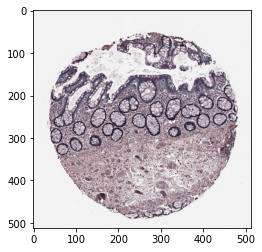

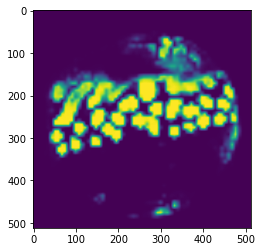

<Figure size 432x288 with 0 Axes>

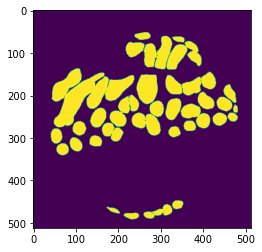

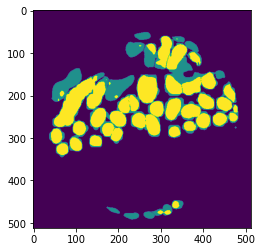

In [42]:
test_batch = return_batch(val_data, 2, (512,512), augment=False)
plt.figure()
plt.imshow(test_batch[0][0][:,:,:3])
plt.figure()
plt.imshow(ksac_network.model(np.expand_dims(test_batch[0][0],0)).numpy().squeeze())
plt.figure()
inference = infer(ksac_network.model, np.expand_dims(test_batch[0][0],0))
#plt.imshow(inference.squeeze())
plt.figure()
plt.imshow(test_batch[1][0])
plt.figure()
plt.imshow((inference.squeeze() + test_batch[1][0])/2)

In [20]:
def ensemble_infer(models, image):
    total_mask = np.zeros((np.shape(image)[1], np.shape(image)[2],1))
    for model in models:
        total_mask += infer(model, image)
    total_mask = (total_mask > len(models)/2).astype(np.uint8)
    return total_mask

In [21]:
def test_model(model, data, img_size=(512,512)):
    indices = range(len(data))
    total_coef = 0
    age_channel = np.zeros((len(data), img_size[0],img_size[1],1))
    organ_channel = np.zeros((len(data), img_size[0],img_size[1],1))
    sex_channel = np.zeros((len(data), img_size[0],img_size[1],1))
    for i in range(0,len(data)):
        
        image = (cv2.imread(('train_images/'+str(data[indices[i]][0])+'.tiff')))
        image = cv2.resize(image, (img_size))
        image = image/255
        
        rle_string = data[indices[i]][-3]
        img_height = data[indices[i]][3]
        #mg_width = data[indices[i]][4]
        
        mask = rle_to_mask(rle_string, img_height)
        mask = cv2.resize(mask, (img_size))
        
        #image, mask = augment_data(image, mask, img_size)
        
        
        organ = data[indices[i]][1]
        sex = data[indices[i]][-1]
        age = data[indices[i]][-2]
        
        
        organ_num = list(organs).index(organ)
        sex_num = list(sexes).index(sex)
        
        """normalising organ number and sex number to be between 0 and 1. Assumed maximum age as 200"""
        organ_num /= len(organs)
        sex_num /= len(sexes)
        age /= 200
        
        age_channel[i] += age
        organ_channel[i] += organ_num
        sex_channel[i] += sex_num
        
        
        image_plus = np.concatenate((image, age_channel[i], organ_channel[i], sex_channel[i]), axis = -1)
        image_plus = np.expand_dims(image_plus, 0)
        inference = infer(model, image_plus).squeeze()
        dice_coefficient = dice_coef((mask), inference)
        total_coef += dice_coefficient

    return total_coef/len(data)

In [22]:
print(test_model(ksac_network.model, val_data))

ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 512, 512, 3), found shape=(1, 512, 512, 6)